In [5]:
import tensorflow as tf
from tensorflow import keras
from visual import save_gan, cvt_gif
import numpy as np
from utils import set_soft_gpu, save_weights
from tensorflow.keras.layers import Input,Conv2D, Dropout, Flatten, Dense, Reshape, Conv2DTranspose, ReLU, BatchNormalization,LeakyReLU 
# from mnist_ds import get_train_x
import time

In [2]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:09:00.0, compute capability: 8.6



# 資料集讀取

In [2]:
train_dir = "./100k_black"
batch_size = 64
def preprocessingDataSet(image):
    image = (image.astype(np.float32))/ 255. * 2 - 1
    return image
train_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessingDataSet)

train_generator = train_datagen.flow_from_directory(
 train_dir,
 target_size=(24,24),
 batch_size=batch_size,
 class_mode=None,
 color_mode="grayscale"
)

Found 10000 images belonging to 1 classes.


# Model

In [14]:
class WGAN(keras.Model):
    """
    Wasserstein 距离作为损失函数， 避免D太强导致G的梯度消失。
    D 最大化 Wasserstein 距离，提高收敛性
    G 最小化 Wasserstein 距离
    Clip D weights，局限住太强的 D，让 G 可以跟上 (Lipschitz 约束)。
    """
    def __init__(self, latent_dim, clip, img_shape):
        super().__init__()
        self.latent_dim = latent_dim
        self.clip = clip
        self.img_shape = img_shape
        self.opt = keras.optimizers.Adam(0.0002, beta_1=0, beta_2=0.9)
        self.g = self._get_generator()
        self._build_d()

    def _build_d(self):
        self.d = self._get_discriminator()

    def call(self, n, training=None, mask=None):
        return self.g.call(tf.random.normal((n, self.latent_dim)), training=training)

    def _get_generator(self):
        model = keras.Sequential(name="generator")
        # [n, 100] -> [n, 6 * 6 * 128] -> [n, 6, 6, 128]
        model.add(Input( shape=self.latent_dim ) )
        model.add(Dense(6 * 6 * 128))
        
        model.add(BatchNormalization())
        model.add(ReLU())
        model.add(Reshape((6, 6, 128)))
        # -> [n, 12, 12, 64]
        model.add(Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(ReLU())
        # -> [n, 24, 24, 32]
        model.add(Conv2DTranspose(32, kernel_size=(4, 4), strides=(2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(ReLU())
        # -> [n, 24, 24, 1]
        model.add(Conv2D(1, (4, 4), padding='same', activation=keras.activations.tanh))
        
        model.summary()
        return model
    def _get_discriminator(self):
        model = keras.Sequential(name="discriminator")
        model.add(Input( shape=self.img_shape ) )
        model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.3))
        
        model.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.3))
        model.add(Flatten())
        model.add(Dense(1))
        model.summary()
        return model

    @staticmethod
    def w_distance(fake, real=None):
        # the distance of two data distributions
        if real is None:
            return tf.reduce_mean(fake)
        else:
            return tf.reduce_mean(fake) - tf.reduce_mean(real)

    def train_d(self, real_img):
        with tf.GradientTape() as tape:
            fake_img = self.call(len(real_img), training=False)
            pred_real = self.d.call(real_img, training=True)
            pred_fake = self.d.call(fake_img, training=True)
            loss = self.w_distance(pred_fake, pred_real)   # maximize W distance
        grads = tape.gradient(loss, self.d.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.d.trainable_variables))
        # clip discriminator's weights
        for w in self.d.trainable_weights:
            w.assign(tf.clip_by_value(w, -self.clip, self.clip))
        return loss

    def train_g(self, n):
        with tf.GradientTape() as tape:
            g_img = self.call(n, training=True)
            pred_fake = self.d.call(g_img, training=False)
            loss = -self.w_distance(pred_fake)       # minimize W distance
        grads = tape.gradient(loss, self.g.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.g.trainable_variables))
        return loss

    
def train(gan, steps, d_loop):
    t0 = time.time()
    for t in range(steps):
        for _ in range(d_loop):
            real_img = train_generator.next()
            real_img = tf.convert_to_tensor(real_img)
            d_loss = gan.train_d(real_img)
        g_loss = gan.train_g(batch_size)
        if t % 1000 == 0:
            t1 = time.time()
            print("t={} | time={:.1f} | d_loss={:.2f} | g_loss={:.2f}".format(
                    t, t1 - t0, d_loss.numpy(), g_loss.numpy(), ))
            t0 = t1
            save_gan(gan, t)
            gan.g.save("./"+str(t)+"/")
    save_weights(gan)
    cvt_gif(gan)
    

In [15]:
LATENT_DIM = 100
CLIP = 0.01
D_LOOP = 5
IMG_SHAPE = (24, 24, 1)
# BATCH_SIZE = 64
STEP = 20001
m = WGAN(LATENT_DIM, CLIP, IMG_SHAPE)

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 4608)              465408    
                                                                 
 batch_normalization_15 (Bat  (None, 4608)             18432     
 chNormalization)                                                
                                                                 
 re_lu_9 (ReLU)              (None, 4608)              0         
                                                                 
 reshape_3 (Reshape)         (None, 6, 6, 128)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 12, 12, 64)       131136    
 ranspose)                                                       
                                                                 
 batch_normalization_16 (Bat  (None, 12, 12, 64)       25

In [16]:
train(m, STEP, D_LOOP)

t=0 | time=0.4 | d_loss=-0.00 | g_loss=-0.00


INFO:tensorflow:Assets written to: ./0/assets


INFO:tensorflow:Assets written to: ./0/assets


t=1000 | time=249.3 | d_loss=-0.00 | g_loss=-0.00


INFO:tensorflow:Assets written to: ./1000/assets


INFO:tensorflow:Assets written to: ./1000/assets


t=2000 | time=254.1 | d_loss=-0.00 | g_loss=-0.00


INFO:tensorflow:Assets written to: ./2000/assets


INFO:tensorflow:Assets written to: ./2000/assets


t=3000 | time=248.1 | d_loss=-0.00 | g_loss=-0.00


INFO:tensorflow:Assets written to: ./3000/assets


INFO:tensorflow:Assets written to: ./3000/assets


t=4000 | time=273.2 | d_loss=-0.00 | g_loss=-0.01


INFO:tensorflow:Assets written to: ./4000/assets


INFO:tensorflow:Assets written to: ./4000/assets


t=5000 | time=261.2 | d_loss=-0.00 | g_loss=-0.01


INFO:tensorflow:Assets written to: ./5000/assets


INFO:tensorflow:Assets written to: ./5000/assets


t=6000 | time=365.4 | d_loss=-0.00 | g_loss=-0.02


INFO:tensorflow:Assets written to: ./6000/assets


INFO:tensorflow:Assets written to: ./6000/assets


t=7000 | time=550.1 | d_loss=-0.00 | g_loss=-0.01


INFO:tensorflow:Assets written to: ./7000/assets


INFO:tensorflow:Assets written to: ./7000/assets


t=8000 | time=799.1 | d_loss=-0.00 | g_loss=-0.01


INFO:tensorflow:Assets written to: ./8000/assets


INFO:tensorflow:Assets written to: ./8000/assets


t=9000 | time=645.4 | d_loss=-0.00 | g_loss=-0.01


INFO:tensorflow:Assets written to: ./9000/assets


INFO:tensorflow:Assets written to: ./9000/assets


t=10000 | time=246.7 | d_loss=-0.00 | g_loss=-0.00


INFO:tensorflow:Assets written to: ./10000/assets


INFO:tensorflow:Assets written to: ./10000/assets


t=11000 | time=246.6 | d_loss=-0.00 | g_loss=0.00


INFO:tensorflow:Assets written to: ./11000/assets


INFO:tensorflow:Assets written to: ./11000/assets


t=12000 | time=246.0 | d_loss=-0.00 | g_loss=-0.00


INFO:tensorflow:Assets written to: ./12000/assets


INFO:tensorflow:Assets written to: ./12000/assets


t=13000 | time=246.3 | d_loss=-0.00 | g_loss=-0.00


INFO:tensorflow:Assets written to: ./13000/assets


INFO:tensorflow:Assets written to: ./13000/assets


t=14000 | time=246.7 | d_loss=-0.00 | g_loss=-0.01


INFO:tensorflow:Assets written to: ./14000/assets


INFO:tensorflow:Assets written to: ./14000/assets


t=15000 | time=246.0 | d_loss=-0.00 | g_loss=-0.01


INFO:tensorflow:Assets written to: ./15000/assets


INFO:tensorflow:Assets written to: ./15000/assets


t=16000 | time=246.9 | d_loss=-0.00 | g_loss=-0.00


INFO:tensorflow:Assets written to: ./16000/assets


INFO:tensorflow:Assets written to: ./16000/assets


t=17000 | time=247.7 | d_loss=-0.00 | g_loss=-0.00


INFO:tensorflow:Assets written to: ./17000/assets


INFO:tensorflow:Assets written to: ./17000/assets


t=18000 | time=246.3 | d_loss=-0.00 | g_loss=-0.00


INFO:tensorflow:Assets written to: ./18000/assets


INFO:tensorflow:Assets written to: ./18000/assets


t=19000 | time=246.9 | d_loss=-0.00 | g_loss=-0.00


INFO:tensorflow:Assets written to: ./19000/assets


INFO:tensorflow:Assets written to: ./19000/assets


t=20000 | time=246.3 | d_loss=-0.00 | g_loss=0.00


INFO:tensorflow:Assets written to: ./20000/assets


INFO:tensorflow:Assets written to: ./20000/assets


saved  visual/wgan/generating.gif


<Figure size 640x480 with 0 Axes>

In [10]:
a = train_generator.next()
a.shape

(2048, 24, 24, 1)

In [7]:
import matplotlib.pyplot as plt
import cv2

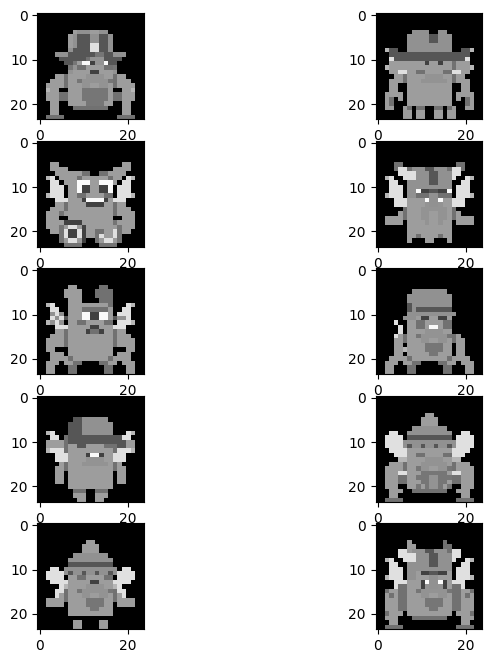

In [8]:
count = 1 
plt.figure(num='img',figsize=(8,8))
for i in range(10):
    
    a = train_generator.next()
    img = a[0].reshape(24,24,1)
    img = (img+1)/2*255
    
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = img.astype('int')
    plt.subplot(5,2,i+1)
    plt.imshow(img)
    
    count+=1
plt.show()

In [5]:
a = train_generator.next()
a

array([[[[-1.       ],
         [-1.       ],
         [-1.       ],
         ...,
         [-1.       ],
         [-1.       ],
         [-1.       ]],

        [[-1.       ],
         [-1.       ],
         [-1.       ],
         ...,
         [-1.       ],
         [-1.       ],
         [-1.       ]],

        [[-1.       ],
         [-1.       ],
         [-1.       ],
         ...,
         [-1.       ],
         [-1.       ],
         [-1.       ]],

        ...,

        [[-1.       ],
         [-1.       ],
         [-1.       ],
         ...,
         [-1.       ],
         [-1.       ],
         [-1.       ]],

        [[-1.       ],
         [-1.       ],
         [-1.       ],
         ...,
         [-1.       ],
         [-1.       ],
         [-1.       ]],

        [[-1.       ],
         [-1.       ],
         [-1.       ],
         ...,
         [-1.       ],
         [-1.       ],
         [-1.       ]]],


       [[[-1.       ],
         [-1.       ],
         [-1. 